# Data Discover and Transformation
in this section of the lab, we'll use Glue to discover new transprotation data

### ASSUMPTION:
1. GlueRole is created in cloudformation
1. Notebook role has access to perform glue and athena query functions (in addition to the otherones)
1. Run all 3 ETLs at the same time with Standard and 5 workers.



A table in the AWS Glue Data Catalog is the metadata definition that represents the data in a data store. You create tables when you run a crawler, or you can create a table manually in the AWS Glue console. The Tables list in the AWS Glue console displays values of your table's metadata. You use table definitions to specify sources and targets when you create ETL (extract, transform, and load) jobs. 

In [ ]:
import boto3

database_name = '2019reinventWorkshop'

## lets first create a namespace for the tables:
glue_client = boto3.client('glue')
create_database_resp = glue_client.create_database(
    DatabaseInput={
        'Name': database_name,
        'Description': 'This database will contain the tables discovered through both crawling and the ETL processes'
    }
)

This will create a new database, or namespace, that can hold the collection of tables
<img src="images/createdatabaseresponse.png">

You can use a crawler to populate the AWS Glue Data Catalog with tables. This is the primary method used by most AWS Glue users. A crawler can crawl multiple data stores in a single run. Upon completion, the crawler creates or updates one or more tables in your Data Catalog. Extract, transform, and load (ETL) jobs that you define in AWS Glue use these Data Catalog tables as sources and targets. The ETL job reads from and writes to the data stores that are specified in the source and target Data Catalog tables. 

In [ ]:
crawler_name = '2019reinventworkshopcrawler'
create_crawler_resp = glue_client.create_crawler(
    Name=crawler_name,
    Role='GlueRole',
    DatabaseName=database_name,
    Description='Crawler to discover the base tables for the workshop',
    Targets={
        'S3Targets': [
            {
                'Path': 's3://serverless-analytics/reinvent-2019/',
            },
        ]
    }
)
response = glue_client.start_crawler(
    Name=crawler_name
)

After starting the crawler, you can go to the glue console if you'd like to see it running.

https://console.aws.amazon.com/glue/home?region=us-east-1#catalog:tab=crawlers
<img src='images/startcrawlerui.png'/>

After it finishes crawling, you can see the datasets (represeted as "tables") it automatically discovered.
<img src='images/crawler_discovered.png'/>

## Quering the data

We'll use Athena to query the data.  Athena allows us to perform SQL queries against datasets on S3, without having to transform them, load them into a traditional sql datastore, and allows rapid ad-hoc investigation.  

Later we'll use Spark to do ETL and feature engineering.

In [12]:
print('installing the PyAthena Drivers to perform SQL queries natively')
print('alternatives include using the boto3 libraries or other Athena Data APIs')
!pip install PyAthena > /dev/null

installing the PyAthena Drivers to perform SQL queries natively
alternatives include using the boto3 libraries or other Athena Data APIs
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Athena uses S3 to store results to allow different types of clients to read it and so you can go back and see the results of previous queries.  We can set that up next:

In [13]:
import sagemaker
sagemaker_session = sagemaker.Session()
athena_data_bucket = sagemaker_session.default_bucket()
print('using the athena data bucket:', athena_data_bucket)
print('running in region: ', sagemaker_session.boto_region_name)

using the athena data bucket: sagemaker-us-east-1-783526147575
running in region:  us-east-1


Next we'll create an Athena connection we can use, much like a standard JDBC/ODBC connection

In [14]:
from pyathena import connect
import pandas as pd

sagemaker_session = sagemaker.Session()

conn = connect(s3_staging_dir="s3://" + athena_data_bucket,
               region_name=sagemaker_session.boto_region_name)

     type  ride_count
0     fhv    31956302
1  yellow    44459136
2   green     3298036


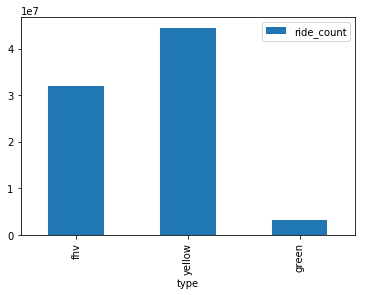

In [28]:
df = pd.read_sql('SELECT \'yellow\' type, count(*) ride_count FROM "' + database_name + '"."yellow" ' + 
                 'UNION ALL SELECT \'green\' type, count(*) ride_count FROM "' + database_name + '"."green"' +
                 'UNION ALL SELECT \'fhv\' type, count(*) ride_count FROM "' + database_name + '"."fhv"', conn)
print(df)
df.plot.bar(x='type', y='ride_count')

## TODO -- ADD DESCRIBE SCHEMA CALLS

In [94]:
green_etl = '2019reinvent_green'
yellow_etl = '2019reinvent_yellow'
fhv_etl = '2019reinvent_fhv'

response = glue_client.start_job_run(
    JobName=green_etl,
    WorkerType='Standard', # other options include: 'G.1X'|'G.2X',
    NumberOfWorkers=5
)
print('response from starting green')
print(response)

response = glue_client.start_job_run(
    JobName=yellow_etl,
    WorkerType='Standard', # other options include: 'G.1X'|'G.2X',
    NumberOfWorkers=5
)
print('response from starting yellow')
print(response)

response = glue_client.start_job_run(
    JobName=fhv_etl,
    WorkerType='Standard', # other options include: 'G.1X'|'G.2X',
    NumberOfWorkers=5
)
print('response from starting fhv')
print(response)


response from starting green
{'JobRunId': 'jr_926f737715e81c82b226c161143d6c6782faad6b34f8a22e4cd446613b3e2170', 'ResponseMetadata': {'RequestId': '6a0da0e4-e84b-11e9-9e2f-abe21cc8b0d0', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 06 Oct 2019 15:10:21 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '82', 'connection': 'keep-alive', 'x-amzn-requestid': '6a0da0e4-e84b-11e9-9e2f-abe21cc8b0d0'}, 'RetryAttempts': 0}}
response from starting yellow
{'JobRunId': 'jr_66979272ac47f8ae88b1f36b42c1d80f4fb02b35e2e037f4497d4f897efb557a', 'ResponseMetadata': {'RequestId': '6a20b373-e84b-11e9-9f07-178aedbcc476', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Sun, 06 Oct 2019 15:10:21 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '82', 'connection': 'keep-alive', 'x-amzn-requestid': '6a20b373-e84b-11e9-9f07-178aedbcc476'}, 'RetryAttempts': 0}}
response from starting fhv
{'JobRunId': 'jr_f598cfba55e94fbdb4d5f201edf3955d051c1eb384266f4d4f5493c5e5b32

after kicking it off, you can see it running in the console too:
<img src="images/ETLStart.png"/>

## TODO: add logic to wait until the 3 jobs finish programmatically...

Now let's look at the total counts for the aggregated information

     type  ride_count
0   green     3298036
1     fhv    31956302
2  yellow    44459136


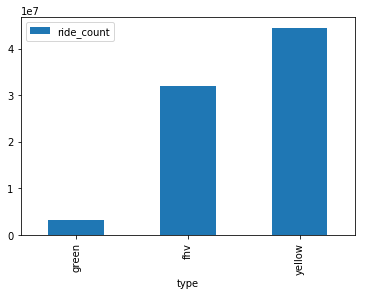

In [40]:
normalized_df = pd.read_sql('SELECT type, count(*) ride_count FROM "reinvent19"."canonical" group by type', conn)
print(normalized_df)
normalized_df.plot.bar(x='type', y='ride_count')
#
#     type  ride_count
#0     fhv    31956302
#1  yellow    44459136
#2   green     3298036


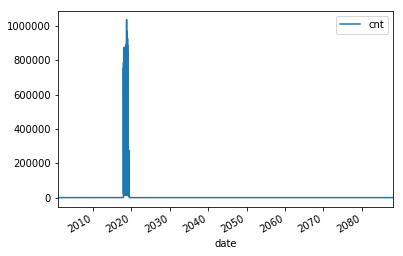

In [143]:
query = "select type, date_trunc('day', pickup_datetime) date, count(*) cnt from reinvent19.canonical where pickup_datetime < timestamp '2099-12-31' group by type, date_trunc('day', pickup_datetime) "
typeperday_df = pd.read_sql(query, conn)
typeperday_df.plot(x='date', y='cnt')

## We see some bad data here...
We are expecting only 2018 and 2019 datasets here, but can see there are records far into the future and in the past.  This represents bad data that we want to eliminate before we build our model.


In [150]:
# Only reason we put this conditional here is so you can execute the cell multiple times
# if you don't check, it won't find the 'date' column again and makes interacting w/ the notebook more seemless
if type(typeperday_df.index) != pd.core.indexes.datetimes.DatetimeIndex:
    print('setting index to date')
    typeperday_df = typeperday_df.set_index('date', drop=True)
    
typeperday_df.head()

,type,cnt
date,,
2019-06-19,yellow,246680
2018-05-01,green,25151
2018-07-28,green,24194
2019-03-09,fhv,38356
2019-06-05,fhv,67823


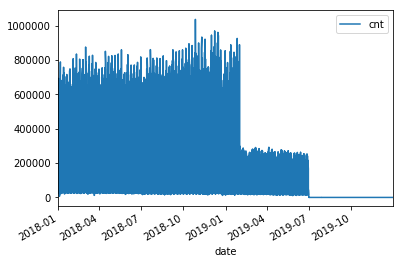

In [149]:
typeperday_df.loc['2018-01-01':'2019-12-31'].plot(y='cnt')

Let's look at some of the bad data now:


All the bad data, at least the bad data in the future, is coming from the yellow taxi license type.

### Note, we are querying the transformed data.

We should check the raw dataset to see if it's also bad or something happened in the ETL process

Let's find the 2 2088 records to make sure they are in the source data

In [108]:
pd.read_sql("select * from reinvent19.yellow where tpep_pickup_datetime like '2088%'", conn)

,vendorid,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,ratecodeid,store_and_fwd_flag,pulocationid,dolocationid,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,2,2088-01-24 00:15:42,2088-01-24 00:19:46,1,0.63,1,N,41,166,2,4.5,0.0,0.5,0.0,0.0,0.3,5.3,None
1,2,2088-01-24 00:25:39,2088-01-24 07:28:25,1,4.05,1,N,24,162,2,14.5,0.0,0.5,0.0,0.0,0.3,15.3,None


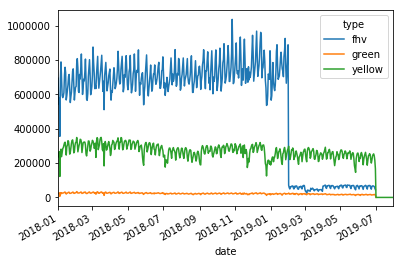

In [147]:
## Next let's plot this per type:
typeperday_df.loc['2018-01-01':'2019-07-30'].pivot_table(index='date', 
                                                         columns='type', 
                                                         values='cnt', 
                                                         aggfunc='sum').plot()

## Let's switch to the EDA/Training notebook now to perform training.